In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.compiler import transpile
from qiskit.visualization import plot_distribution, plot_histogram, plot_bloch_multivector
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import get_image_path
from scipy.optimize import minimize_scalar, OptimizeResult, minimize
from qiskit.providers.fake_provider import FakeMelbourne

![diagram](./assets/buckshot-roulette-diagram.png)

In [42]:
player_strategy = lambda bullets, fakes: "himself" if(bullets == fakes or fakes > bullets) else "shoot"
dealer_strategy = lambda bullets, fakes:  "himself" if np.random.randint(2) else "shoot"

In [43]:
def gun(bullets, fakes) -> bool:
    v = bullets + fakes
    r = np.random.randint(1, v+1)
    return r <= bullets
    

def play(strategies:dict, players:list, total_bullets:int, total_fakes:int, debug:bool=False) -> pd.DataFrame:
    lives = {
        "player":0,
        "dealer":0
    }

    actual_player = players[0]
    oponent = players[1]
    rounds = 0
    while(total_bullets):
        player = strategies[actual_player]
        action = player(total_bullets, total_fakes)
        shot = gun(total_bullets, total_fakes)

        if(debug):
            print(f"playing: {actual_player}")
            print(f"oponent: {oponent}")
            print(f"action: {action}")
            print(f"shot: {shot}")
        

        if(action == "shoot" and shot):
            lives[oponent] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        elif(action == "shoot" and not shot):
            total_fakes -=1
            actual_player,oponent = oponent,actual_player

        elif(action == "himself" and shot):
            lives[actual_player] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        else:
            total_fakes -=1            

        if(debug):
            print(lives, end="\n\n")

        rounds += 1

    if(lives['player'] > lives['dealer']):
        return 'player', rounds
    elif(lives['dealer'] > lives['player']):
        return 'dealer', rounds
    else:
        return 'draw', rounds


In [44]:
play({"player":player_strategy, "dealer":dealer_strategy}, ("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



('dealer', 1)

In [45]:
def get_experiment_results(n:int, players_strategies:dict, players:list, total_bullets:int, total_fakes:int):
    df = pd.DataFrame(columns=("total_player", "total_dealer"))
    n_rounds = pd.Series()

    j = 1000
    for i in range(n):
        results = {"player":0, "dealer":0}
        for _ in range(j):
            result, rounds = play(players_strategies, players, total_bullets, total_fakes)
            results[result]+=1
            n_rounds.loc[j*i + j] = rounds
        df.loc[i] = {"total_player":results['player'], "total_dealer":results['dealer']}
    return df, n_rounds

3    348
2    335
1    317
Name: count, dtype: int64


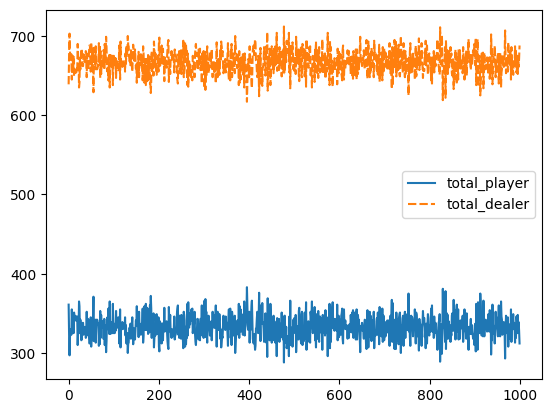

In [46]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.savefig(get_image_path("first_classical_player_strategy.png"))
plt.show()

3    370
1    338
2    292
Name: count, dtype: int64


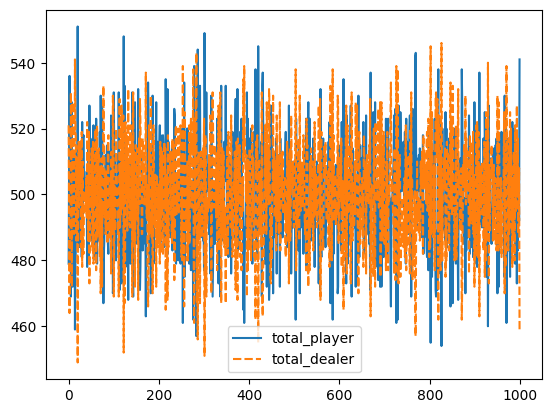

In [47]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":dealer_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.savefig(get_image_path("two_players_same_strategy.png"))
plt.show()

2    349
3    330
1    321
Name: count, dtype: int64


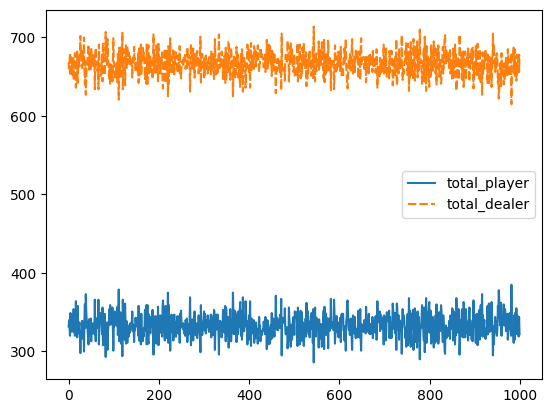

In [127]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":player_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [48]:
def player_start_himself_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'himself'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    366
1    331
3    303
Name: count, dtype: int64


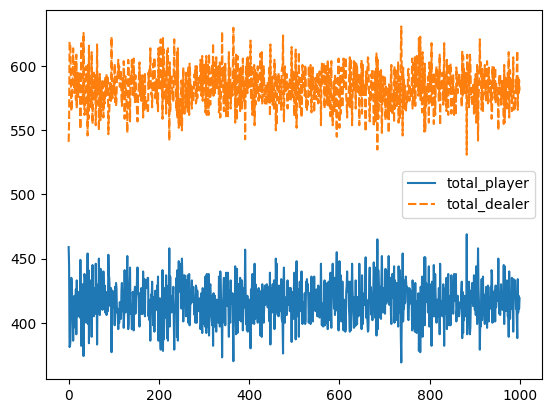

In [128]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [49]:
def player_optimal_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'shoot'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    1054
1     997
3     949
Name: count, dtype: int64


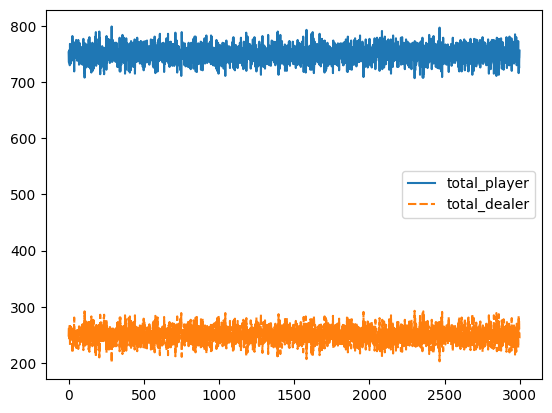

In [50]:
df,rounds = get_experiment_results(n=3000, players_strategies={"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.savefig(get_image_path("optimal_player_strategy.png"))
plt.show()

In [135]:
df,rounds = play({"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the first strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# player shoot (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



2

In [148]:
df,rounds = play({"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the second strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# player shoot himself (second round)
# player shoot the dealer (second round)
# dealer shoot the player (third round)
# dealer shoot himself (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



1

In [155]:
df,rounds = play({"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the third strategy, there're some possible ways to finish the game

# player shoot the dealer (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# dealer shoot himself (third round)
# dealer shoot the player (third round)
# player shoot the dealer(third round)

# so the dealer loses most part of the time
# as in the first play the player chooses to shoot the dealer, he has more chances to live, once he's removed one of the dying chances

playing: player
oponent: dealer
action: shoot
shot: True
{'player': 0, 'dealer': -1}



1

---

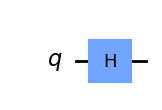

In [4]:
player = QuantumCircuit(1, name="Player")
player.h(0)
player.draw('mpl', style="clifford")

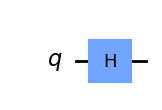

In [5]:
dealer = QuantumCircuit(1, name="Dealer")
dealer.h(0)
player.draw('mpl', style="clifford")

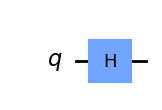

In [6]:
gun = QuantumCircuit(1, name="shoot")
gun.h(0)
gun.draw('mpl', style='clifford')

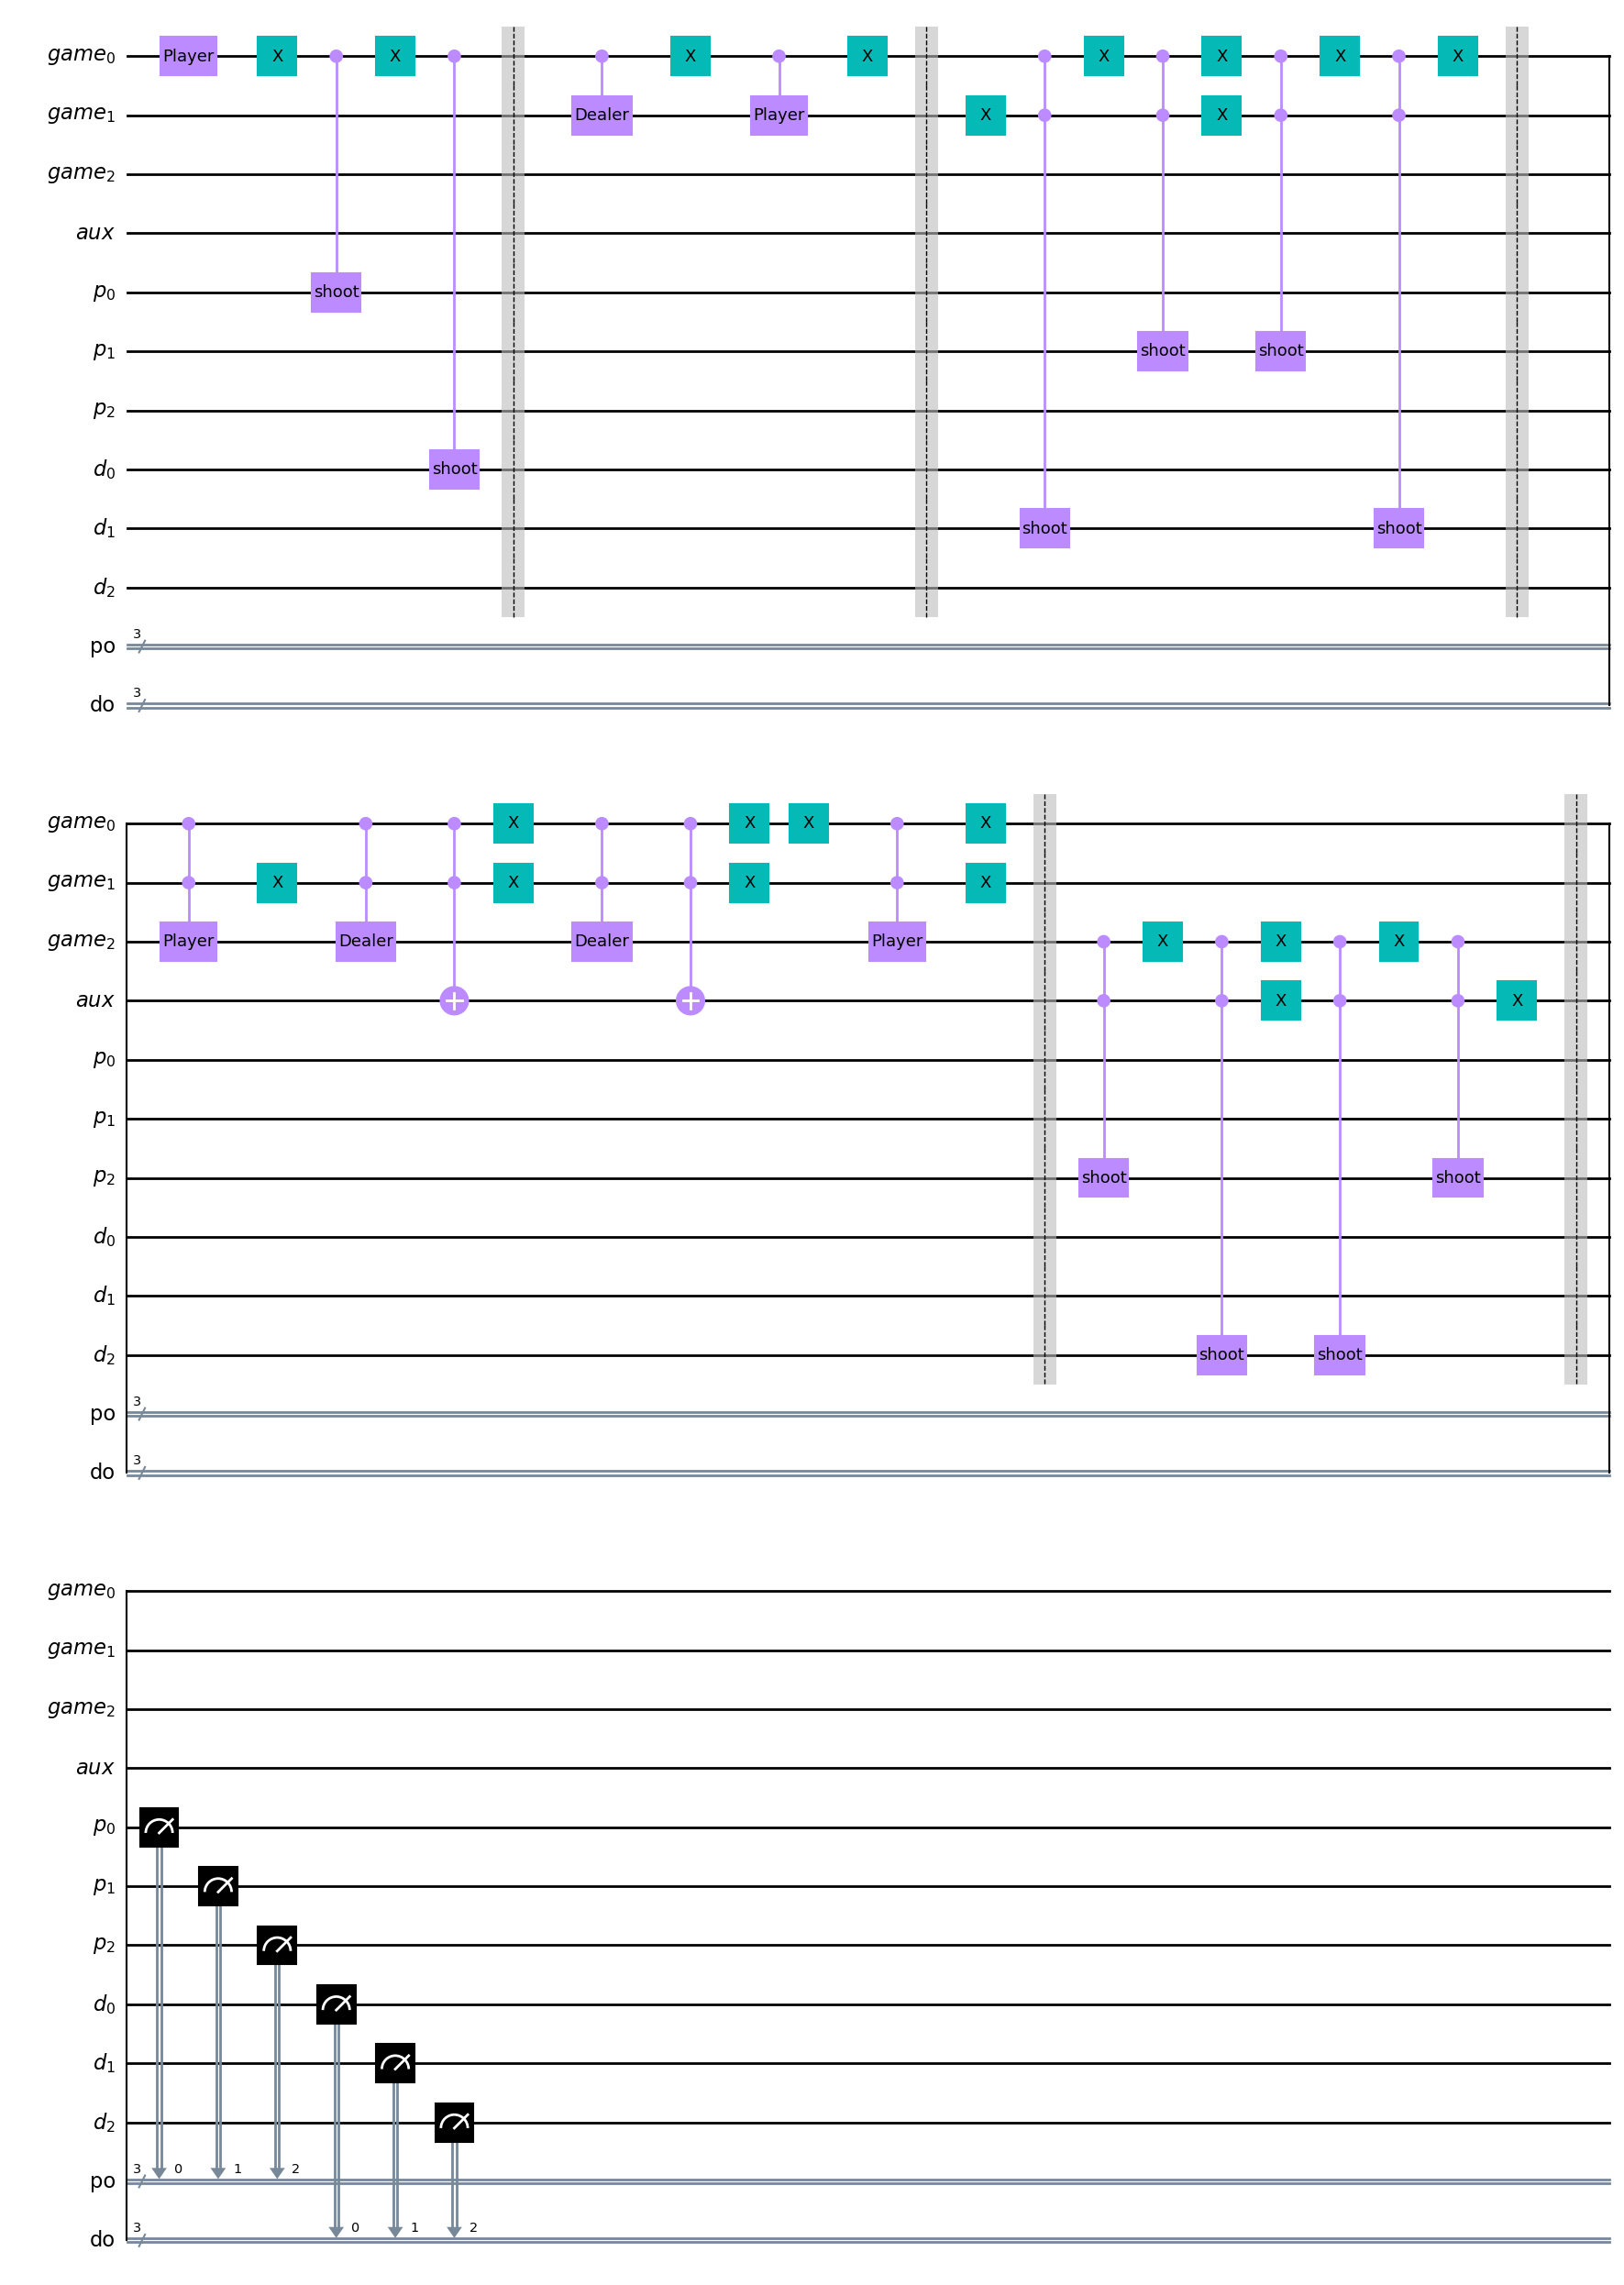

In [7]:
def buckshot_roulette(player, dealer, gun):
    player_gate = player.to_gate()
    player_controlled_gate = player.to_gate().control(1)
    player_two_controlled_gate = player.to_gate().control(2)
    
    dealer_controlled_gate = dealer.to_gate().control(1)
    dealer_two_controlled_gate = dealer.to_gate().control(2)
    
    gun_controlled_gate = gun.to_gate().control(1)
    gun_two_controlled_gate = gun.to_gate().control(2)
    
    player_life  = QuantumRegister(3, name="p") 
    dealer_life  = QuantumRegister(3, name="d")
    game = QuantumRegister(3, name="game")
    player_life_out = ClassicalRegister(3, name="po")
    dealer_life_out = ClassicalRegister(3, name="do")
    aux = AncillaRegister(1, name="aux")
    
    qc = QuantumCircuit(game, aux, player_life, dealer_life, player_life_out, dealer_life_out)
    
    qc.append(player.copy(), [game[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], player_life[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], dealer_life[0]])
    
    #next_player
    # 0 = player, 1 = dealer
    
    qc.barrier()
    
    qc.append(dealer_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.append(player_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.barrier()
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    
    qc.barrier()
    
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    
    qc.x(game[1])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[1])
    
    qc.x(game[0])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[0])
    
    qc.x([game[0], game[1]])
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    qc.x([game[0], game[1]])
    qc.barrier()
    
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.x(aux)
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(aux)
    
    
    qc.barrier()
    qc.measure(player_life, player_life_out)
    qc.measure(dealer_life, dealer_life_out)
    
    return qc


qc = buckshot_roulette(player, dealer, gun)
qc.draw('mpl', style="clifford", filename=get_image_path("quantum_buckshot_roulette.png"))

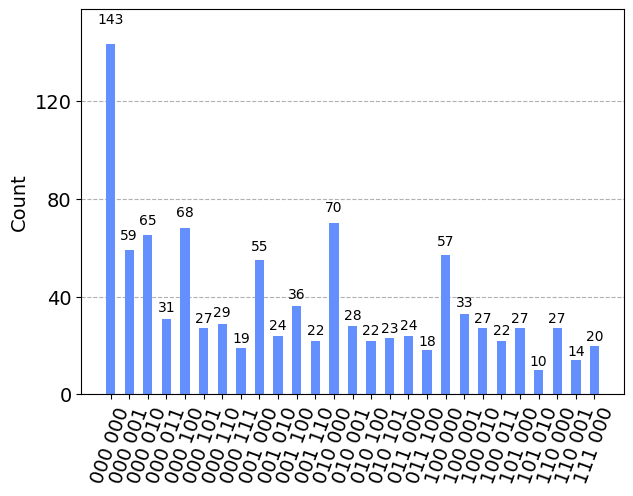

In [9]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [10]:
def parse_results(results):
    wins = {'dealer':0, 'player':0}
    for d,v in results.items():
        #v_bin = f"{v:06b}"
        if(d.count("1") > 3):
            continue
        
        bin_dealer, bin_player = d[:3], d[4:]

        #first_match
        first_dealer, first_player = bin_dealer[-1], bin_player[-1]
        #second_match
        second_dealer, second_player = bin_dealer[-2], bin_player[-2]
        #third_match
        third_dealer, third_player = bin_dealer[-3], bin_player[-3]

        if(first_dealer != first_player):
            winner = "dealer" if first_dealer == '0' else "player"
            wins[winner]+=v
            continue
            
        if(second_dealer != second_player):
            winner = "dealer" if second_dealer == '0' else "player"
            wins[winner]+=v
            continue
            
        if(third_dealer != third_player):
            winner = "dealer" if third_dealer == '0' else "player"
            wins[winner]+= v
            continue
        
    return wins    
parse_results(result)

{'dealer': 445, 'player': 412}

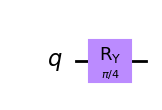

In [8]:
player_2 = QuantumCircuit(1)
player_2.ry(np.pi/4, 0)
player_2.draw('mpl', style='clifford')

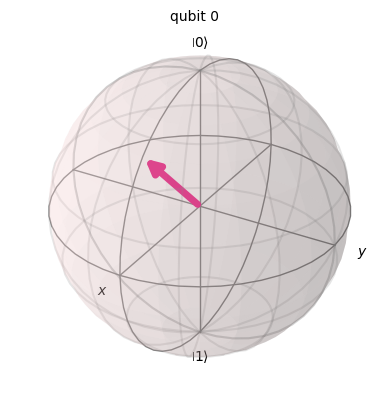

In [11]:
plot_bloch_multivector(player_2)

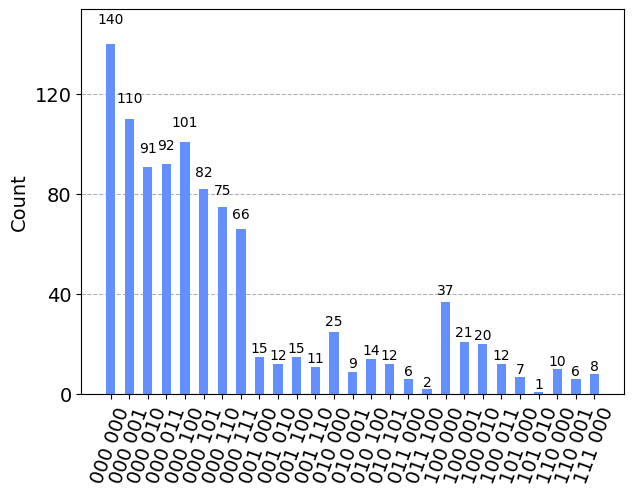

In [9]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player_2, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [10]:
parse_results(result)

{'dealer': 697, 'player': 163}

In [11]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    phi = Parameter('phi')
    lam = Parameter('lambda')
    
    player_var.u(theta, phi, lam, 0)

    player_var = player_var.assign_parameters({theta:x[0], phi:x[1], lam:x[2]})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

minimized = minimize(
    x0=[0, 0, 0],
    bounds=[(0, np.pi), (0, 2*np.pi), (0,None)],
    fun=obj, 
    args=(AerSimulator(), 1000),
    method="COBYLA")
minimized

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


{'dealer': 885, 'player': 0} [0. 0. 0.]
{'dealer': 626, 'player': 236} [1. 0. 0.]
{'dealer': 659, 'player': 217} [1. 1. 0.]
{'dealer': 626, 'player': 230} [1. 0. 1.]
{'dealer': 305, 'player': 565} [ 1.99198046 -0.12639133  0.        ]
{'dealer': 171, 'player': 704} [ 2.98668512 -0.22916602  0.        ]
{'dealer': 170, 'player': 699} [ 3.3571506  -0.93805367 -0.60019466]
{'dealer': 145, 'player': 727} [ 3.39152189 -0.60539113 -0.97188572]
{'dealer': 308, 'player': 568} [ 4.29383127 -0.17609666 -0.9325915 ]
{'dealer': 159, 'player': 711} [ 2.95356856 -0.63519129 -1.21127834]
{'dealer': 188, 'player': 685} [ 3.48536378 -0.78230046 -1.12154129]
{'dealer': 166, 'player': 710} [ 3.33144767 -0.15702799 -0.75890315]
{'dealer': 156, 'player': 716} [ 3.57090232 -0.62134461 -1.14528742]
{'dealer': 170, 'player': 708} [ 3.2862352  -0.61890543 -1.03789388]
{'dealer': 175, 'player': 703} [ 3.38886934 -0.54351996 -0.98032206]
{'dealer': 160, 'player': 708} [ 3.42441392 -0.71071937 -0.91315687]
{'deal

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 143.0
       x: [ 3.399e+00 -6.313e-01 -9.559e-01]
    nfev: 39
   maxcv: 0.0

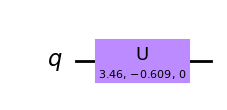

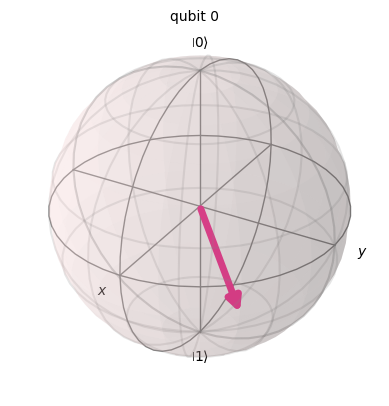

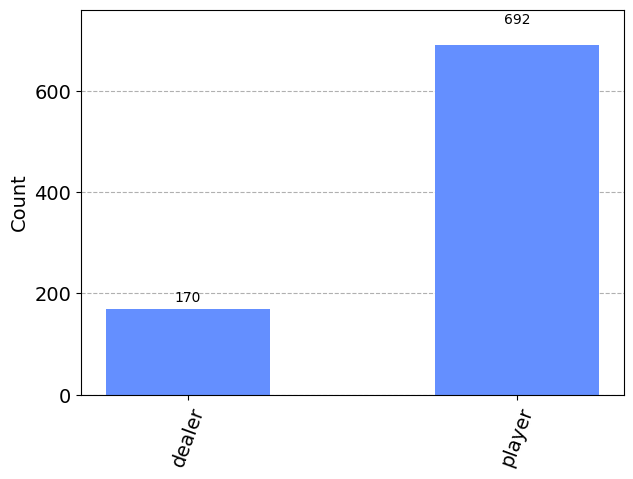

In [12]:
player_optimal = QuantumCircuit(1)
player_optimal.u(minimized.x[0], minimized.x[1],0, 0)
display(player_optimal.draw('mpl', style='clifford'))
qc = buckshot_roulette(player_optimal, dealer, gun)
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
display(plot_bloch_multivector(player_optimal))
plot_histogram(parse_results(result))

In [14]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    player_var.ry(theta, 0)
    player_var = player_var.assign_parameters({theta:x})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

def custom_minimizer(fun, args, **kwargs):
    bounds = kwargs['bounds']
    best_x = 0
    best_y = 100000
    rounds = 0
    
    for v in np.arange(bounds[0], bounds[1], 0.01):
        y = fun(v,args[0], args[1])
        if(y < best_y):
            best_y = y
            best_x = v
    
        rounds+=1
    print(best_x, best_y)

    return OptimizeResult(fun=best_y, x=best_x, nit=0, nfev=rounds, success=True)

minimized = minimize_scalar(
    fun=obj, 
    bounds=(0, 2*np.pi),
    args=(AerSimulator(), 1000),
    method=custom_minimizer)

minimized

{'dealer': 868, 'player': 0} 0.0
{'dealer': 855, 'player': 0} 0.01
{'dealer': 863, 'player': 0} 0.02
{'dealer': 875, 'player': 0} 0.03
{'dealer': 871, 'player': 0} 0.04
{'dealer': 884, 'player': 1} 0.05
{'dealer': 877, 'player': 1} 0.06
{'dealer': 859, 'player': 1} 0.07
{'dealer': 862, 'player': 2} 0.08
{'dealer': 865, 'player': 3} 0.09
{'dealer': 865, 'player': 1} 0.1
{'dealer': 858, 'player': 2} 0.11
{'dealer': 867, 'player': 3} 0.12
{'dealer': 877, 'player': 5} 0.13
{'dealer': 871, 'player': 4} 0.14
{'dealer': 867, 'player': 1} 0.15
{'dealer': 860, 'player': 6} 0.16
{'dealer': 874, 'player': 13} 0.17
{'dealer': 864, 'player': 12} 0.18
{'dealer': 869, 'player': 11} 0.19
{'dealer': 850, 'player': 13} 0.2
{'dealer': 887, 'player': 12} 0.21
{'dealer': 843, 'player': 19} 0.22
{'dealer': 865, 'player': 13} 0.23
{'dealer': 861, 'player': 20} 0.24
{'dealer': 860, 'player': 16} 0.25
{'dealer': 830, 'player': 26} 0.26
{'dealer': 860, 'player': 19} 0.27
{'dealer': 854, 'player': 26} 0.28
{'dea

 success: True
     fun: 137
       x: 2.79
     nit: 0
    nfev: 629

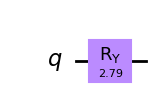

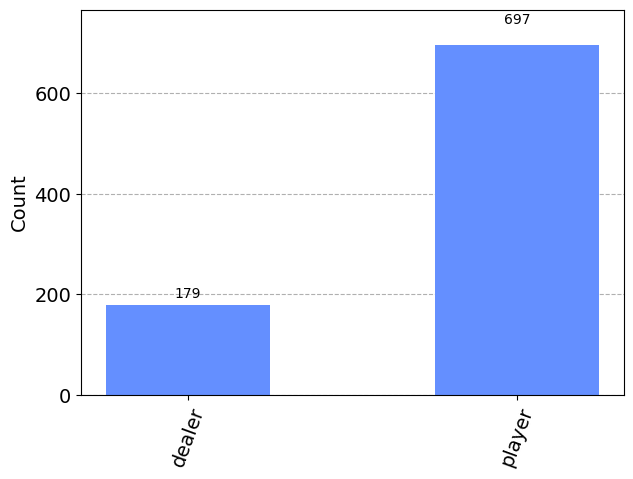

In [15]:
player_optimal = QuantumCircuit(1)
player_optimal.ry(minimized.x, 0)
display(player_optimal.draw('mpl', style='clifford'))
qc = buckshot_roulette(player_optimal, dealer, gun)
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(parse_results(result))

In [12]:
def obj(x, sim, shots):
    player_var = QuantumCircuit(1)
    theta = Parameter('theta')
    phi = Parameter('phi')
    
    player_var.u(theta, phi, 0, 0)

    player_var = player_var.assign_parameters({theta:x[0], phi:x[1]})
    qc = buckshot_roulette(player_var, dealer, gun)
    
    transpiled_qc = transpile(qc, sim)
    result = sim.run(transpiled_qc, shots=shots).result().get_counts()
    
    parsed_result = parse_results(result)
    print(parsed_result, x)
    return parsed_result['dealer']

def custom_minimizer(fun, x0, args, **kwargs):
    bounds = kwargs['bounds']
    best_x = []
    best_y = 100000
    rounds = 0

    for i in np.arange(bounds[0][0], bounds[0][1], 0.1):
        for j in np.arange(bounds[1][0], bounds[1][1], 0.1):
            y = fun([i, j], args[0], args[1])
            if(y < best_y):
                best_y = y
                best_x = [i, j]
            
            rounds+=1
                
    print(best_x, best_y)

    return OptimizeResult(fun=best_y, x=best_x, nit=0, nfev=rounds, success=True)

minimized = minimize(
    x0=[0, 0],
    bounds=[(np.pi/4, np.pi), (np.pi/4, 2*np.pi)],
    fun=obj, 
    args=(AerSimulator(), 1000),
    method=custom_minimizer)
minimized

{'dealer': 708, 'player': 156} [0.7853981633974483, 0.7853981633974483]
{'dealer': 720, 'player': 147} [0.7853981633974483, 0.8853981633974483]
{'dealer': 721, 'player': 141} [0.7853981633974483, 0.9853981633974482]
{'dealer': 732, 'player': 140} [0.7853981633974483, 1.085398163397448]
{'dealer': 745, 'player': 136} [0.7853981633974483, 1.1853981633974482]
{'dealer': 720, 'player': 142} [0.7853981633974483, 1.2853981633974483]
{'dealer': 693, 'player': 165} [0.7853981633974483, 1.3853981633974481]
{'dealer': 742, 'player': 133} [0.7853981633974483, 1.485398163397448]
{'dealer': 741, 'player': 151} [0.7853981633974483, 1.585398163397448]
{'dealer': 728, 'player': 157} [0.7853981633974483, 1.6853981633974482]
{'dealer': 729, 'player': 130} [0.7853981633974483, 1.785398163397448]
{'dealer': 750, 'player': 128} [0.7853981633974483, 1.885398163397448]
{'dealer': 724, 'player': 139} [0.7853981633974483, 1.985398163397448]
{'dealer': 739, 'player': 144} [0.7853981633974483, 2.085398163397448]

 success: True
     fun: 135
       x: [3.0853981633974477, 5.685398163397447]
     nit: 0
    nfev: 1320

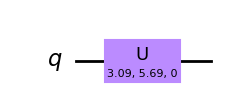

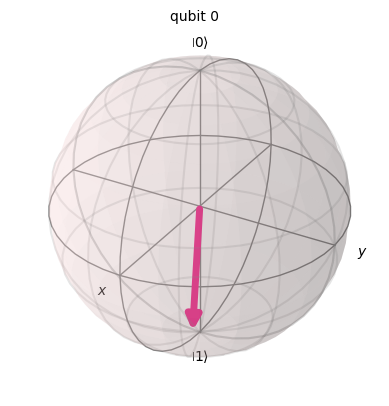

In [13]:
player_optimal = QuantumCircuit(1)
player_optimal.u(minimized.x[0], minimized.x[1],0, 0)
display(player_optimal.draw('mpl', style='clifford'))
plot_bloch_multivector(player_optimal)

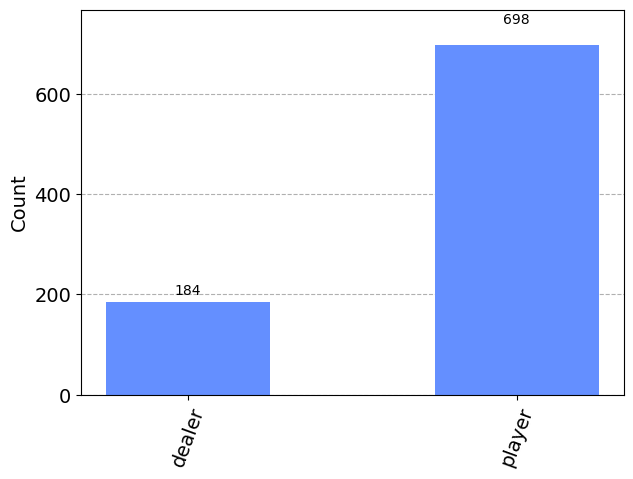

In [20]:
qc = buckshot_roulette(player_optimal, dealer, gun)
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
parsed_results = parse_results(result)
plot_histogram(parsed_results, filename=get_image_path("final_buckshot_roulette_quantum_optimal_strategy.png"))
plot_histogram(parsed_results)

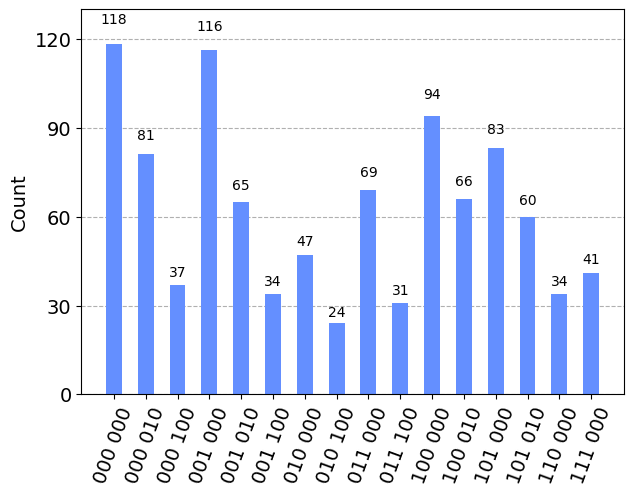

In [21]:
plot_histogram(result, filename=get_image_path("final_buckshot_roulette_quantum_optimal_strategy_bit_strings.png"))
plot_histogram(result)

In [22]:
transpiled = transpile(buckshot_roulette(player_optimal, dealer, gun), backend=FakeMelbourne(), optimization_level=3)
transpiled.depth()

1022

In [23]:
exp_result = FakeMelbourne().run(transpiled, shots=1000).result().get_counts()
exp_result

{'001 001': 1,
 '001 011': 1,
 '010 011': 1,
 '100 001': 1,
 '110 001': 2,
 '101 111': 2,
 '001 101': 1,
 '101 001': 1,
 '011 101': 1,
 '100 111': 1,
 '011 011': 2,
 '000 101': 2,
 '100 011': 2,
 '110 011': 3,
 '000 111': 1,
 '101 011': 3,
 '010 110': 40,
 '000 000': 43,
 '011 100': 18,
 '111 100': 28,
 '110 100': 34,
 '001 111': 1,
 '101 010': 27,
 '101 100': 35,
 '000 100': 47,
 '000 010': 36,
 '110 110': 32,
 '010 111': 1,
 '010 100': 25,
 '000 001': 2,
 '000 110': 40,
 '111 000': 24,
 '101 000': 35,
 '011 000': 28,
 '100 110': 21,
 '010 000': 35,
 '001 010': 33,
 '101 110': 26,
 '011 010': 17,
 '100 100': 39,
 '001 110': 30,
 '111 010': 28,
 '100 000': 36,
 '110 000': 27,
 '011 110': 19,
 '100 010': 25,
 '010 010': 24,
 '010 001': 1,
 '111 110': 20,
 '110 010': 24,
 '111 101': 3,
 '001 000': 35,
 '001 100': 36}

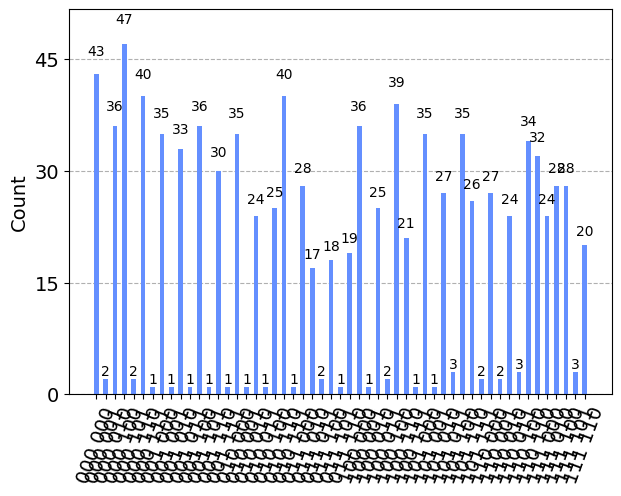

In [24]:
plot_histogram(exp_result, filename=get_image_path("final_buckshot_roulette_quantum_optimal_strategy_bit_strings_fake_melbourne.png"))
plot_histogram(exp_result)

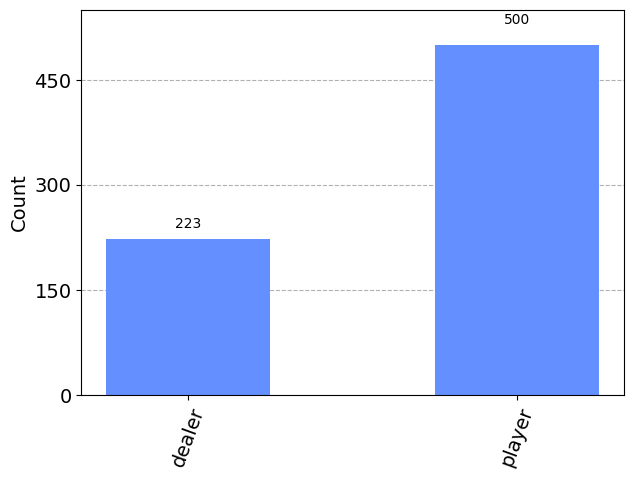

In [25]:
parsed_results = parse_results(exp_result)
plot_histogram(parsed_results, filename=get_image_path("final_buckshot_roulette_quantum_optimal_strategy_fake_melbourne.png"))
plot_histogram(parsed_results)